# Airline Tweets - Topic Modeling


## Initialize Notebook

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string

from gensim.models import LdaModel
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis.gensim

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm
import statsmodels.formula.api as smf

## Prepare Data

In [2]:
# Load data from CSV file
tweets = pd.read_csv("https://raw.githubusercontent.com/kbrennig/MODS_WS24_25/refs/heads/main/data/airlinetweets.csv")

In [3]:
# Split dataset into training and test sets
X = tweets.drop(columns=['sentiment_human', 'tweet_id', 'airline', 'tweet_created'])
y = tweets['sentiment_human']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
#Define function with all necessary preprocessing steps
def preprocess(text):
    # tokenize the text
    tokens = nltk.word_tokenize(text)

    # create stemmer object
    stemmer = nltk.stem.PorterStemmer()

    # stem each token
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # get list of stopwords in English
    stopwords = nltk.corpus.stopwords.words("english")
    stopwords.extend(['@', 'http', 'https', 'www', 'com', 'co', 'amp', 'flight', 'americanair', 'unit', 'usairway', 'southwestair', 'jetblu'])

    # remove stopwords
    filtered_tokens = [token for token in stemmed_tokens if token.lower() not in stopwords]

    # remove punctuation
    filtered_tokens_nopunct = [token for token in filtered_tokens if token not in string.punctuation]

    return filtered_tokens_nopunct

In [5]:
# Preprocess text data
X_train['tokens'] = X_train['text'].apply(preprocess)
X_test['tokens'] = X_test['text'].apply(preprocess)


In [6]:
X_train

,text,tokens
9254,@AmericanAir stiiiil waiting. Please respond a...,"[stiiiil, wait, pleas, respond, leav, 2, 1/2, hr]"
1561,@AmericanAir yes we did make it home. But by n...,"[ye, make, home, mean, happi, 've, alway, chos..."
1670,@united Would be nice if @staralliance partner...,"[would, nice, staralli, partner, ticket, n't, ..."
6087,@united just DM'd,"[dm, 'd]"
6669,@USAirways owes Tammy from the Winston-Salem c...,"[owe, tammi, winston-salem, call, center, keep..."
...,...,...
5734,@USAirways I just think it's weird to have mil...,"[think, 's, weird, mileag, 666]"
5191,@AmericanAir Is it possible to change the FF n...,"[possibl, chang, ff, number, passeng, book, pr..."
5390,@USAirways - just passed the 3 hour mark #onho...,"[pass, 3, hour, mark, onholdwith, thi, call, g..."
860,@AmericanAir at gate c11. Your gate agents are...,"[gate, c11, gate, agent, turn, pay, custom, aw..."


## Topic Modeling

In [7]:
# Create dictionary
dictionary = corpora.Dictionary(X_train['tokens'])
dictionary.filter_extremes(no_below=5)
dictionary.filter_n_most_frequent(10)

In [8]:
# Construct corpus (i.e., lists of words per doc)
corpus_train = [dictionary.doc2bow(tokens) for tokens in X_train['tokens']]
corpus_test = [dictionary.doc2bow(tokens) for tokens in X_test['tokens']]

In [9]:
# Train LDA model
k = 30
lda_model = LdaModel(corpus_train, num_topics=k, minimum_probability=0.0, id2word = dictionary, iterations=100, random_state=42)

In [10]:
# Loop to extract per-topic term distribution
per_topic_term_dist = pd.DataFrame(columns=["word_id", "prob"])
for i in range(0, k):
    this_term_dist = pd.DataFrame(lda_model.get_topic_terms(i, topn=10), columns=["word_id", "prob"])
    this_term_dist["word"] = this_term_dist["word_id"].apply(lambda x: dictionary[x])
    this_term_dist["topic_id"] = i
    per_topic_term_dist = pd.concat([per_topic_term_dist, this_term_dist])

In [11]:
per_topic_term_dist[per_topic_term_dist["topic_id"] == 22].sort_values(by="prob", ascending=False)

,word_id,prob,word,topic_id
0,420,0.027015,look,22.0
1,232,0.023927,anyth,22.0
2,178,0.023869,time,22.0
3,9,0.020288,...,22.0
4,132,0.018000,board,22.0
5,520,0.016335,mayb,22.0
6,389,0.015719,abl,22.0
7,273,0.013427,seat,22.0
8,1042,0.012876,rock,22.0
9,315,0.012009,vega,22.0


In [12]:
# Function to extract per-document topic distributions
def get_document_topic_distribution(model, corpus):
    """Get topic distributions for each document in a corpus."""
    return pd.DataFrame(
        [
            [prob for _, prob in model.get_document_topics(doc, minimum_probability=0)]
            for doc in corpus
        ],
        columns=[f'Topic{i+1}' for i in range(model.num_topics)]
    )

train_topic_distributions = get_document_topic_distribution(lda_model, corpus_train)
test_topic_distributions = get_document_topic_distribution(lda_model, corpus_test)

In [13]:
train_topic_distributions

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,...,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30
0,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,...,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167
1,0.002381,0.002381,0.002381,0.383578,0.002381,0.002381,0.157459,0.002381,0.002381,0.131037,...,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381,0.002381
2,0.002778,0.919439,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,...,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778,0.002778
3,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,...,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.677775,0.011111
4,0.005557,0.005557,0.005557,0.629200,0.005557,0.005557,0.005557,0.005557,0.005557,0.005557,...,0.005557,0.005557,0.005557,0.005557,0.005557,0.005557,0.005557,0.005557,0.005557,0.005557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112,0.344430,0.011112,0.011112,...,0.011112,0.011112,0.011112,0.344447,0.011112,0.011112,0.011112,0.011112,0.011112,0.011112
7996,0.003333,0.003333,0.003333,0.003333,0.003333,0.252823,0.003333,0.108271,0.003333,0.003333,...,0.003333,0.003333,0.003333,0.003333,0.003333,0.003333,0.548902,0.003333,0.003333,0.003333
7997,0.004167,0.004167,0.275126,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,...,0.131941,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167,0.004167
7998,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.003704,0.219696,...,0.003704,0.395629,0.003704,0.003704,0.003704,0.003704,0.284668,0.003704,0.003704,0.003704


## Random Forest Classifier

In [14]:
# Train Random Forest with topic distributions as features
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_topic_distributions, y_train)


RandomForestClassifier(random_state=42)

Accuracy: 0.8175


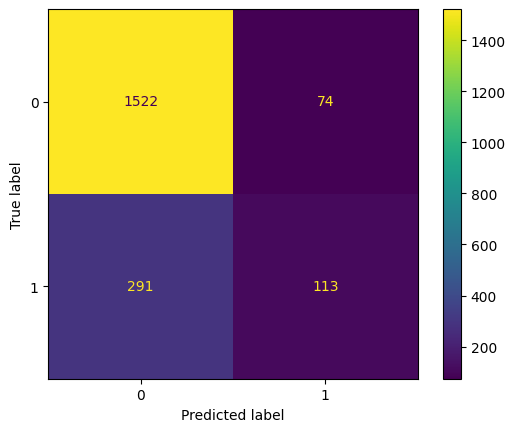

In [15]:
# Convert y_test to binary labels
y_test_binary = y_test.apply(lambda x: 1 if x == 'positive' else 0)

# Make predictions on test set
pred_prob_rf = rf_model.predict_proba(test_topic_distributions)[:, 1]
pred_binary_rf = (pred_prob_rf > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_binary, pred_binary_rf)
print(f"Accuracy: {accuracy}")

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test_binary, pred_binary_rf)

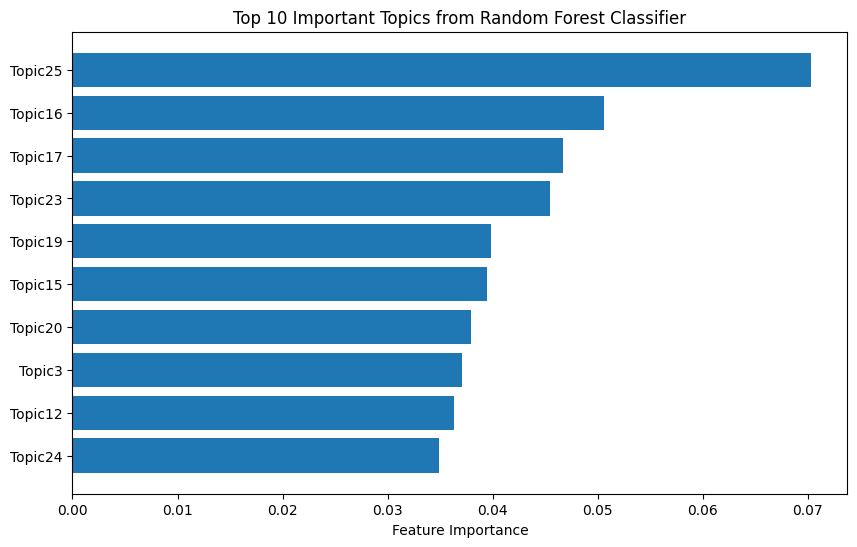

In [16]:
# Show feature importance from Random Forest

# Get feature importances from the trained Random Forest model
importances = rf_model.feature_importances_

# Get the feature names (topics in the LDA model)
feature_names = train_topic_distributions.columns

# Sort the features by importance
indices = np.argsort(importances)[::-1]

# Plot the top 10 most important features
top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances[indices[:top_n]], align='center')
plt.yticks(range(top_n), np.array(feature_names)[indices[:top_n]])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Topics from Random Forest Classifier')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()